# Example: Radar processing

The processing of radar data - often referred to as SAR data, which stands for Synthetice Aperture Radar - is a topic of its own and quite different from optical data that uses Red, Green, Blue, NIR and similar bands.
This is the first of a series of jupyter notebooks where example SAR workflows will be explained that can be run on UP42.
All of the examples are based on a specific type of analysis which is called polarimetry and processes one image at a time.
In comparison to polarimetric there also is interferometric analysis which leverages the information encoded in suitable pairs of radar image. 

In this notebook we want to have a look at the Sentinel-1 GRD full scene block, followed by SNAP Sentinel-1 Polarimetric Processing. Polarimetric SAR Processing turns a Sentinel-1 GRD image into a multichannel GeoTIFF that is ready for analysis. 

 - Prepare workflow
 - Define aoi and input parameters
 - Run Job
 - Visualize results

In [1]:
import up42

In [3]:
# Authenticate with UP42
up42.authenticate(cfg_file="config.json")
#up42.authenticate(project_id=12345, project_api_key=12345)

2020-05-26 14:19:56,546 - up42.auth - INFO - Got credentials from config file.
2020-05-26 14:19:57,155 - up42.auth - INFO - Authentication with UP42 successful!


## Prepare UP42 workflows

Create a new project on UP42 or use an existing one.

In [5]:
S1_SNAP_project = up42.initialize_project()

2020-05-26 14:20:10,960 - up42 - INFO - Working on Project with project_id d3ea9123-2b89-4975-be16-e978fed8329c


Create workflow and check available blocks and data

In [6]:
workflow = S1_SNAP_project.create_workflow(name="S1-GRD_SNAP", 
                                   use_existing=True)
print(up42.get_blocks(basic=True))

2020-05-26 14:20:14,765 - up42.project - INFO - Getting existing workflows in project ...
2020-05-26 14:20:15,434 - up42.project - INFO - Got 12 workflows for project d3ea9123-2b89-4975-be16-e978fed8329c.
100%|██████████| 12/12 [00:07<00:00,  1.52it/s]
2020-05-26 14:20:23,341 - up42.project - INFO - Using existing workflow: S1-GRD_SNAP, 1585a205-3907-4905-bd02-057a17c3cf84.
2020-05-26 14:20:24,728 - up42.tools - INFO - Getting blocks name and id, use basic=False for all block details.


{'tiling': 'd350aa0b-ac31-4021-bbe6-fd8da366740a', 'oneatlas-spot-aoiclipped': '0f15e07f-efcc-4598-939b-18aade349c57', 'oneatlas-pleiades-aoiclipped': 'f026874d-e95e-4293-b811-7667130e054d', 'sobloo-s1-grd-fullscene': '4524e2de-c780-488d-9818-fe68dad9f095', 'sobloo-s2-l1c-fullscene': '604988cb-8252-4161-bf28-f6fb63d7371c', 'snap-polarimetric': '320158d6-8f93-4484-a828-e1fb64f677ff', 'sentinelhub-s2-aoiclipped': 'c4758545-4b74-4318-ae1f-d5ba72f234ca', 'sentinelhub-landsat8-aoiclipped': 'e0b133ae-7b9c-435c-99ac-c4527cc8d9cf', 'sobloo-s1-slc-fullscene': 'cf822545-c73c-467b-8f43-5311dbefe03f', 'nasa-modis': '61279eb8-02e1-4b7a-ac3d-1f62d19d3484', 's2-superresolution': '4872fef8-aec8-4dec-adcb-560ee4430a2b', 'oneatlas-pleiades-fullscene': '8487adcd-a4d7-4cb7-b826-75a533e1f330', 'oneatlas-spot-fullscene': 'aa62113f-0dd1-40a3-a004-954c9d087071', 'data-conversion': '470eedda-5f62-433c-8562-98eb8783af87', 'pansharpen': '2f24c662-c129-409f-a7c3-afa16a4c78cb', 'sobloo-s1-grd-aoiclipped': 'a956166

In [7]:
# Fill the workflow with tasks
input_tasks= ['sobloo-s1-grd-fullscene', 'snap-polarimetric']
workflow.add_workflow_tasks(input_tasks=input_tasks)
workflow.get_parameters_info()

2020-05-26 14:21:03,273 - up42.workflow - INFO - Added tasks to workflow: [{'name': 'sobloo-s1-grd-fullscene:1', 'parentName': None, 'blockId': '4524e2de-c780-488d-9818-fe68dad9f095'}, {'name': 'snap-polarimetric:1', 'parentName': 'sobloo-s1-grd-fullscene:1', 'blockId': '320158d6-8f93-4484-a828-e1fb64f677ff'}]
2020-05-26 14:21:04,000 - up42.workflow - INFO - Got 2 tasks/blocks in workflow 1585a205-3907-4905-bd02-057a17c3cf84.


{'sobloo-s1-grd-fullscene:1': {'ids': {'type': 'array', 'default': None},
  'bbox': {'type': 'array', 'default': None},
  'time': {'type': 'dateRange',
   'default': '2018-01-01T00:00:00+00:00/2020-12-31T23:59:59+00:00'},
  'limit': {'type': 'integer', 'default': 1, 'minimum': 1},
  'contains': {'type': 'geometry'},
  'intersects': {'type': 'geometry'},
  'time_series': {'type': 'array', 'default': None},
  'orbit_direction': {'type': 'string', 'default': None},
  'acquisition_mode': {'type': 'string', 'default': None}},
 'snap-polarimetric:1': {'bbox': {'type': 'array', 'default': None},
  'mask': {'type': 'array',
   'items': {'enum': ['land', 'sea'], 'type': 'string'},
   'default': None},
  'contains': {'type': 'geometry', 'default': None},
  'intersects': {'type': 'geometry', 'default': None},
  'clip_to_aoi': {'type': 'boolean', 'default': False},
  'tcorrection': {'type': 'boolean', 'default': True},
  'linear_to_db': {'type': 'boolean', 'default': True},
  'polarisations': {'ty

## Define aoi and input parameters

The S1 GRD block always delivers the complete images as they are delivered in SAFE format which cannot be clipped.
The image can be clipped though by the SNAP polarimetric processing blocks. For this it is necessary to supply the same geometry (in this case a bbox) to that block as well. 



In [8]:
input_parameters = {
  "sobloo-s1-grd-fullscene:1": {
    "bbox": [13.371037, 52.512799, 13.382624, 52.518747],
    "ids": None,
    "time": "2018-01-01T00:00:00+00:00/2020-12-31T23:59:59+00:00",
    "limit": 1,
    "zoom_level": 14,
  },
    "snap-polarimetric:1": {
    "bbox": [13.371037, 52.512799, 13.382624, 52.518747],
    "mask": None,
    "contains": None,
    "intersects": None,
    "clip_to_aoi": True,
    "tcorrection": True,
    "linear_to_db": True,
    "polarisations": [
        "VV"
   ],
   "speckle_filter": True,
   "calibration_band": [
         "sigma"
   ]
  }
}

## Run test query
Run a test job to query data availability and check the configuration.

In [9]:
test_job = workflow.test_job(input_parameters=input_parameters, track_status=True)
test_results = test_job.get_results_json()
print(test_results)

2020-05-26 14:21:14,155 - up42.workflow - INFO - +++++++++++++++++++++++++++++++++
2020-05-26 14:21:14,157 - up42.workflow - INFO - Running this job as Test Query...
2020-05-26 14:21:14,157 - up42.workflow - INFO - +++++++++++++++++++++++++++++++++
2020-05-26 14:21:14,158 - up42.workflow - INFO - Selected input_parameters: {'sobloo-s1-grd-fullscene:1': {'bbox': [13.371037, 52.512799, 13.382624, 52.518747], 'ids': None, 'time': '2018-01-01T00:00:00+00:00/2020-12-31T23:59:59+00:00', 'limit': 1, 'zoom_level': 14}, 'snap-polarimetric:1': {'bbox': [13.371037, 52.512799, 13.382624, 52.518747], 'mask': None, 'contains': None, 'intersects': None, 'clip_to_aoi': True, 'tcorrection': True, 'linear_to_db': True, 'polarisations': ['VV'], 'speckle_filter': True, 'calibration_band': ['sigma']}, 'config': {'mode': 'DRY_RUN'}}.
2020-05-26 14:21:15,659 - up42.workflow - INFO - Created and running new job: 28c72c74-a5dc-46e3-bb70-f6efad3f910c.
2020-05-26 14:21:16,144 - up42.job - INFO - Tracking job sta

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'bbox': [12.306028, 52.168652, 16.66515, 54.078037], 'id': '5a0bcc6b-8316-45c9-9106-8de8e27e5753', 'geometry': {'type': 'Polygon', 'coordinates': [[[16.151102, 52.168652], [16.66515, 53.660217], [12.685362, 54.078037], [12.306028, 52.5835], [16.151102, 52.168652]]]}, 'properties': {'attachments': [], 'visibility': {'deleted': False}, 'illumination': {}, 'production': {'levelCode': 'L1', 'ongoing': False, 'timeliness': 'Fast-24h'}, 'archive': {'offLine': False, 'filename': 'S1A_IW_GRDH_1SDV_20200525T051659_20200525T051724_032717_03CA2F_DB50.SAFE', 'size': 1689, 'format': 'SAFE', 'onLine': False}, 'spatialCoverage': {'verticality': {}, 'geometry': {'geographicBoundingPolygon': {'coordinates': [[[16.151102, 52.168652], [16.66515, 53.660217], [12.685362, 54.078037], [12.306028, 52.5835], [16.151102, 52.168652]]], 'type': 'Polygon'}, 'global': False, 'centerPoint': {'lon': 14.45556570632881, 'lat': 53.12652491313295}}}, 'quality

## Run the job

In [10]:
job = workflow.run_job(input_parameters=input_parameters, track_status=True)

2020-05-26 14:21:44,963 - up42.workflow - INFO - Selected input_parameters: {'sobloo-s1-grd-fullscene:1': {'bbox': [13.371037, 52.512799, 13.382624, 52.518747], 'ids': None, 'time': '2018-01-01T00:00:00+00:00/2020-12-31T23:59:59+00:00', 'limit': 1, 'zoom_level': 14}, 'snap-polarimetric:1': {'bbox': [13.371037, 52.512799, 13.382624, 52.518747], 'mask': None, 'contains': None, 'intersects': None, 'clip_to_aoi': True, 'tcorrection': True, 'linear_to_db': True, 'polarisations': ['VV'], 'speckle_filter': True, 'calibration_band': ['sigma']}}.
2020-05-26 14:21:46,310 - up42.workflow - INFO - Created and running new job: 2e0e9cf0-8d80-439a-bc50-179543641ea9.
2020-05-26 14:21:46,734 - up42.job - INFO - Tracking job status continuously, reporting every 30 seconds...
2020-05-26 14:22:21,006 - up42.job - INFO - Job is RUNNING! - 2e0e9cf0-8d80-439a-bc50-179543641ea9
2020-05-26 14:23:06,480 - up42.job - INFO - Job is RUNNING! - 2e0e9cf0-8d80-439a-bc50-179543641ea9
2020-05-26 14:23:40,185 - up42.job

## Visualize the results

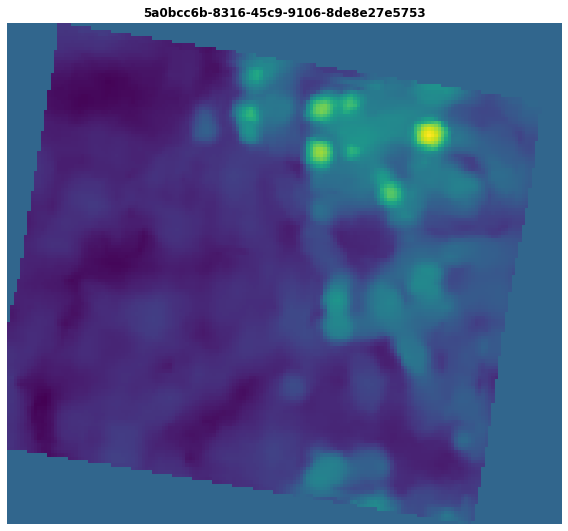

In [12]:
# Download results:
job.download_results()

# Visualize downloaded results
job.plot_results()

## Next processing steps
The output of the workflow is a GeoTIFF file which can be processed by different algorithms. It is for example possible to apply raster tiling and then do some machine learning based analysis at the end.

